<a href="https://colab.research.google.com/github/miramnair/Machine-Learning-Classification-Model-for-UK-Car-Accidents/blob/main/python_pyspark_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import and check the version
import pyspark
print(pyspark.__version__)

3.3.2


<font size =5> Import and test pyspark </font>

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('spark_coursework') \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/17 21:17:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
rdd = spark.sparkContext.parallelize([1, 2, 3, 4, 5])
rdd.collect()

[1, 2, 3, 4, 5]

<font size = 5>  Import libraries</font>

In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, VectorSlicer, ChiSqSelector
from pyspark.sql.functions import col, split, substring, date_format, to_date, when, count
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, isnull, length, trim
from pyspark.sql.functions import lit, udf
from pyspark.sql.types import DoubleType
from math import radians, sin, cos, sqrt, asin
import pandas as pd
from pyspark.sql.functions import corr
from pyspark.ml.pipeline import Pipeline
import time
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import floor
from pyspark.ml.feature import RFormula, StandardScaler
import geopy
from geopy.distance import great_circle
from pyspark.sql.functions import mean
from pyspark.sql.functions import corr
from pyspark.sql.functions import count
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation

In [ ]:
# read the first CSV file
casualty = spark.read.format("csv").option("header", "true").load('/Users/meeranair/Documents/Coventry/7153CEM/dft-road-casualty-statistics-casualty-last-5-years.csv',header = True, \
                              inferSchema=True).alias("casualty")
casualty.printSchema()

# get the number of rows
num_rows = casualty.count()
# get the number of columns
num_cols = len(casualty.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)


root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- casualty_reference: integer (nullable = true)
 |-- casualty_class: integer (nullable = true)
 |-- sex_of_casualty: integer (nullable = true)
 |-- age_of_casualty: integer (nullable = true)
 |-- age_band_of_casualty: integer (nullable = true)
 |-- casualty_severity: integer (nullable = true)
 |-- pedestrian_location: integer (nullable = true)
 |-- pedestrian_movement: integer (nullable = true)
 |-- car_passenger: integer (nullable = true)
 |-- bus_or_coach_passenger: integer (nullable = true)
 |-- pedestrian_road_maintenance_worker: integer (nullable = true)
 |-- casualty_type: integer (nullable = true)
 |-- casualty_home_area_type: integer (nullable = true)
 |-- casualty_imd_decile: integer (nullable = true)



Number of rows:  781716
Number of columns:  18


In [ ]:
#drop duplicates
casualty = casualty.dropDuplicates(['accident_index'])

In [ ]:
#drop duplicates
casualty = casualty.dropDuplicates(['accident_index'])


#check for null values
null_cols = [c for c in casualty.columns if casualty.filter((col(c).isNull()) | (col(c) == "NULL")).count() > 0]

print("Columns with null values:", null_cols)

#check for NaN values
nan_cols = [c for c in casualty.columns if casualty.filter(isnan(col(c))).count() > 0]
print("Columns with NaN values:", nan_cols)

#check for empty or blank strings
blank_cols = [c for c in casualty.columns if casualty.filter((length(trim(col(c))) == 0)).count() > 0]
print("Columns with empty or blank strings:", blank_cols)

#check if any columns contain -1 (missing values)
cols_with_neg1 = []
for c in casualty.columns:
    count = casualty.filter(col(c) == -1).count()
    if count > 0:
        cols_with_neg1.append(c)
        print(f"Column {c} has {count} rows with a value of -1")


Columns with null values: []


Columns with NaN values: []


Columns with empty or blank strings: []


Column sex_of_casualty has 524 rows with a value of -1
Column age_of_casualty has 8373 rows with a value of -1
Column age_band_of_casualty has 8373 rows with a value of -1


Column pedestrian_location has 12 rows with a value of -1
Column pedestrian_movement has 16 rows with a value of -1
Column car_passenger has 564 rows with a value of -1
Column bus_or_coach_passenger has 159 rows with a value of -1
Column pedestrian_road_maintenance_worker has 419 rows with a value of -1
Column casualty_type has 10 rows with a value of -1


Column casualty_home_area_type has 71353 rows with a value of -1
Column casualty_imd_decile has 71501 rows with a value of -1


In [ ]:
#drop columns with too many missing values
casualty = casualty.drop('casualty_home_area_type','casualty_imd_decile','age_of_casualty','age_band_of_casualty',
                            'sex_of_casualty')

#delete the rows containing -1 (missing values) and print number of rows that were deleted
conditions = [col(c) == -1 for c in casualty.columns]
count = casualty.filter(reduce(lambda x, y: x | y, conditions)).count()
accidents1_filtered = casualty.filter(reduce(lambda x, y: x | y, conditions))
print("Number of rows deleted with at least one -1 value:", count)

#drop the filtered rows
accidents1_filtered = casualty.subtract(accidents1_filtered)
casualty = accidents1_filtered



Number of rows deleted with at least one -1 value: 1168


In [ ]:
#drop  irrelevant column
casualty = casualty.drop('pedestrian_location','pedestrian_movement', 'casualty_reference', 'accident_reference',
                         'vehicle_reference','accident_year')

casualty.printSchema()

#get the number of rows
num_rows = casualty.count()

#get the number of columns
num_cols = len(casualty.columns)

#print the results
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)



root
 |-- accident_index: string (nullable = true)
 |-- casualty_class: integer (nullable = true)
 |-- casualty_severity: integer (nullable = true)
 |-- car_passenger: integer (nullable = true)
 |-- bus_or_coach_passenger: integer (nullable = true)
 |-- pedestrian_road_maintenance_worker: integer (nullable = true)
 |-- casualty_type: integer (nullable = true)

23/04/17 11:52:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of rows:  596805
Number of columns:  7


In [ ]:
#read the second (vehicle) CSV file
vehicle = spark.read.format("csv").option("header", "true").load('/Users/meeranair/Documents/Coventry/7153CEM/dft-road-casualty-statistics-vehicle-last-5-years.csv',header = True, \
                              inferSchema=True).alias("vehicle")
vehicle.printSchema()
# get the number of rows
num_rows = vehicle.count()
# get the number of columns
num_cols = len(vehicle.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- vehicle_type: integer (nullable = true)
 |-- towing_and_articulation: integer (nullable = true)
 |-- vehicle_manoeuvre: integer (nullable = true)
 |-- vehicle_direction_from: integer (nullable = true)
 |-- vehicle_direction_to: integer (nullable = true)
 |-- vehicle_location_restricted_lane: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- skidding_and_overturning: integer (nullable = true)
 |-- hit_object_in_carriageway: integer (nullable = true)
 |-- vehicle_leaving_carriageway: integer (nullable = true)
 |-- hit_object_off_carriageway: integer (nullable = true)
 |-- first_point_of_impact: integer (nullable = true)
 |-- vehicle_left_hand_drive: integer (nullable = true)
 |-- journey_purpose_of_driver: integer (nullable = true)
 |-- sex_of_driver: integer

In [ ]:
#drop duplicates
vehicle = vehicle.dropDuplicates(['accident_index'])

In [ ]:
#drop duplicates
vehicle = vehicle.dropDuplicates(['accident_index'])
# Check for null values
null_cols = [c for c in vehicle.columns if vehicle.filter((col(c).isNull()) | (col(c) == "NULL")).count() > 0]
print("Columns with null values:", null_cols)

#check for NaN values
nan_cols = [c for c in vehicle.columns if vehicle.filter(isnan(col(c))).count() > 0]
print("Columns with NaN values:", nan_cols)

#check for empty or blank strings
blank_cols = [c for c in vehicle.columns if vehicle.filter((length(trim(col(c))) == 0)).count() > 0]
print("Columns with empty or blank strings:", blank_cols)

cols_with_neg1 = []
for c in vehicle.columns:
    count = vehicle.filter(col(c) == -1).count()
    if count > 0:
        cols_with_neg1.append(c)
        print(f"Column {c} has {count} rows with a value of -1")

Columns with null values: []


Columns with NaN values: []


Columns with empty or blank strings: []
Column vehicle_type has 844 rows with a value of -1
Column towing_and_articulation has 1414 rows with a value of -1
Column vehicle_manoeuvre has 1206 rows with a value of -1


Column vehicle_direction_from has 4267 rows with a value of -1
Column vehicle_direction_to has 4492 rows with a value of -1
Column vehicle_location_restricted_lane has 1263 rows with a value of -1


Column junction_location has 509 rows with a value of -1
Column skidding_and_overturning has 1069 rows with a value of -1
Column hit_object_in_carriageway has 1216 rows with a value of -1
Column vehicle_leaving_carriageway has 1282 rows with a value of -1
Column hit_object_off_carriageway has 8 rows with a value of -1
Column first_point_of_impact has 1837 rows with a value of -1
Column vehicle_left_hand_drive has 1024 rows with a value of -1
Column journey_purpose_of_driver has 120 rows with a value of -1


Column sex_of_driver has 27 rows with a value of -1
Column age_of_driver has 65576 rows with a value of -1
Column age_band_of_driver has 65576 rows with a value of -1
Column engine_capacity_cc has 127322 rows with a value of -1
Column propulsion_code has 125950 rows with a value of -1
Column age_of_vehicle has 126297 rows with a value of -1


Column generic_make_model has 529716 rows with a value of -1
Column driver_imd_decile has 119057 rows with a value of -1


Column driver_home_area_type has 118919 rows with a value of -1


In [ ]:
#drop columns with too many missing values and also irrelevant columns
vehicle = vehicle.drop('driver_home_area_type','driver_imd_decile','generic_make_model','age_of_vehicle',
                            'propulsion_code','engine_capacity_cc','age_band_of_driver','age_of_driver', 'accident_year',
                            'vehicle_direction_to','vehicle_direction_from','accident_reference','vehicle_reference','sex_of_driver')

#delete the rows containing -1 (missing values) and print number of rows that were deleted
conditions = [col(c) == -1 for c in vehicle.columns]
count = vehicle.filter(reduce(lambda x, y: x | y, conditions)).count()
accidents2_filtered = vehicle.filter(reduce(lambda x, y: x | y, conditions))
print("Number of rows deleted with at least one -1 value:", count)

#drop the filtered rows
accidents2_filtered = vehicle.subtract(accidents2_filtered)
vehicle = accidents2_filtered


Number of rows deleted with at least one -1 value: 4627


In [ ]:
vehicle = vehicle.drop('vehicle_manoeuvre')
vehicle.printSchema()

#get the number of rows
num_rows = vehicle.count()

#get the number of columns
num_cols = len(vehicle.columns)

# print the results
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)


root
 |-- accident_index: string (nullable = true)
 |-- vehicle_type: integer (nullable = true)
 |-- towing_and_articulation: integer (nullable = true)
 |-- vehicle_location_restricted_lane: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- skidding_and_overturning: integer (nullable = true)
 |-- hit_object_in_carriageway: integer (nullable = true)
 |-- vehicle_leaving_carriageway: integer (nullable = true)
 |-- hit_object_off_carriageway: integer (nullable = true)
 |-- first_point_of_impact: integer (nullable = true)
 |-- vehicle_left_hand_drive: integer (nullable = true)
 |-- journey_purpose_of_driver: integer (nullable = true)



Number of rows:  593346
Number of columns:  12


In [ ]:
accidents3 = spark.read.format("csv").option("header", "true").load('/Users/meeranair/Documents/Coventry/7153CEM/dft-road-casualty-statistics-accident-last-5-years.csv',header = True, \
                              inferSchema=True).alias("accidents3")

accidents3.printSchema()
#get the number of rows
num_rows = accidents3.count()
#get the number of columns
num_cols = len(accidents3.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- location_easting_osgr: string (nullable = true)
 |-- location_northing_osgr: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- local_authority_district: integer (nullable = true)
 |-- local_authority_ons_district: string (nullable = true)
 |-- local_authority_highway: string (nullable = true)
 |-- first_road_class: integer (nullable = true)
 |-- first_road_number: integer (nullable = true)
 |-- road_type: integer (nullable = true)
 |-- speed_limit: string (nullable

In [ ]:
#convert into double type
accidents3 = accidents3.withColumn("latitude", col("latitude").cast("double"))
accidents3 = accidents3.withColumn("longitude", col("longitude").cast("double"))
accidents3 = accidents3.withColumn("location_easting_osgr", col("location_easting_osgr").cast("double"))
accidents3 = accidents3.withColumn("location_northing_osgr", col("location_northing_osgr").cast("double"))

In [ ]:
#check correlation of geolocation columns
corr_value = accidents3.limit(200).select(corr("longitude", "location_easting_osgr")).collect()[0][0]
print("Correlation between longitude and location_easting_osgr: ", corr_value)

corr_value = accidents3.limit(200).select(corr("latitude", "location_northing_osgr")).collect()[0][0]
print("Correlation between latitude and location_northing_osgr: ", corr_value)


Correlation between longitude and location_easting_osgr:  0.9998404965212871
Correlation between latitude and location_northing_osgr:  0.9993090059436579


In [ ]:
#Extract hour from time of accident
accidents3 = accidents3.withColumn("hour", date_format(col("time"), "HH").cast("int"))
#get month ffrom date of accident
accidents3 = accidents3.withColumn("month", split("date", "/").getItem(1).cast("int"))


In [ ]:
#drop the columns whose information has been extracted
accidents3 = accidents3.drop('date','time','location_easting_osgr','location_northing_osgr')

In [ ]:
#drop duplicates
accidents3 = accidents3.dropDuplicates(['accident_index'])

In [ ]:
#drop duplicates
accidents3 = accidents3.dropDuplicates(['accident_index'])

#check for null values
null_cols = [c for c in accidents3.columns if accidents3.filter((col(c).isNull()) | (col(c) == "NULL")).count() > 0]
print("Columns with null values:", null_cols)

#check for NaN values
nan_cols = [c for c in accidents3.columns if accidents3.filter(isnan(col(c))).count() > 0]
print("Columns with NaN values:", nan_cols)

#check for empty or blank strings
blank_cols = [c for c in accidents3.columns if accidents3.filter((length(trim(col(c))) == 0)).count() > 0]
print("Columns with empty or blank strings:", blank_cols)

#check for missing values (-1)
cols_with_neg1 = []
for c in accidents3.columns:
    count = accidents3.filter(col(c) == -1).count()
    if count > 0:
        cols_with_neg1.append(c)
        print(f"Column {c} has {count} rows with a value of -1")


Columns with null values: ['longitude', 'latitude', 'speed_limit']


Columns with NaN values: []


Columns with empty or blank strings: []


Column local_authority_district has 991 rows with a value of -1


Column local_authority_highway has 3154 rows with a value of -1
Column road_type has 1 rows with a value of -1


Column speed_limit has 92 rows with a value of -1
Column junction_detail has 7 rows with a value of -1
Column junction_control has 251177 rows with a value of -1
Column second_road_class has 212717 rows with a value of -1
Column second_road_number has 212773 rows with a value of -1
Column pedestrian_crossing_human_control has 743 rows with a value of -1
Column pedestrian_crossing_physical_facilities has 694 rows with a value of -1
Column light_conditions has 16 rows with a value of -1
Column weather_conditions has 34 rows with a value of -1
Column road_surface_conditions has 1786 rows with a value of -1


Column special_conditions_at_site has 713 rows with a value of -1
Column carriageway_hazards has 747 rows with a value of -1
Column urban_or_rural_area has 1 rows with a value of -1
Column did_police_officer_attend_scene_of_accident has 3 rows with a value of -1
Column trunk_road_flag has 52298 rows with a value of -1
Column lsoa_of_accident_location has 31492 rows with a value of -1


In [ ]:
#get list of columns with null values
null_cols = [c for c in accidents3.columns if (accidents3.filter(col(c).isNull()).count() + accidents3.filter(col(c) == "NULL").count()) > 0]


#count the number of null values in each column
for col_name in null_cols:
    null_count = accidents3.filter((col(col_name).isNull()) | (col(col_name) == "NULL")).count()
    print(f"Column '{col_name}' has {null_count} null values.")

Column 'longitude' has 133 null values.
Column 'latitude' has 133 null values.
Column 'speed_limit' has 37 null values.


In [ ]:
#drop NULL values
accidents3 = accidents3.replace("NULL", None)
accidents3 = accidents3.dropna()

In [ ]:
#drop columns with too many missing values
accidents3 = accidents3.drop('lsoa_of_accident_location','trunk_road_flag','second_road_number','second_road_class',
                             'junction_control')


#delete the rows containing -1 (missing values) and print number of rows that were deleted
conditions = [col(c) == -1 for c in accidents3.columns]
count = accidents3.filter(reduce(lambda x, y: x | y, conditions)).count()
accidents3_filtered = accidents3.filter(reduce(lambda x, y: x | y, conditions))
print("Number of rows deleted with at least one -1 value:", count)

#drop the filtered rows
accidents3_filtered = accidents3.subtract(accidents3_filtered)
accidents3 = accidents3_filtered



Number of rows deleted with at least one -1 value: 6820


<font size =5> Replace latitude and longitude to avg distance from the mean location </font>

In [ ]:
#calculate the mean of the latitude and longitude columns
center_lat, center_lon = accidents3.agg(mean("latitude"), mean("longitude")).first()

#define the UDF to calculate distance
def calculate_distance(lat, lon):
    return great_circle((lat, lon), (center_lat, center_lon)).kilometers

distance_udf = udf(calculate_distance, DoubleType())

#apply the UDF to create a new column called "distance_km"
accidents3 = accidents3.withColumn("distance_km", distance_udf(col("latitude"), col("longitude")))

#drop latitude and longitude
accidents3 = accidents3.drop('latitude','longitude')

In [ ]:
accidents3.printSchema()

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- local_authority_district: integer (nullable = true)
 |-- local_authority_ons_district: string (nullable = true)
 |-- local_authority_highway: string (nullable = true)
 |-- first_road_class: integer (nullable = true)
 |-- first_road_number: integer (nullable = true)
 |-- road_type: integer (nullable = true)
 |-- speed_limit: string (nullable = true)
 |-- junction_detail: integer (nullable = true)
 |-- pedestrian_crossing_human_control: integer (nullable = true)
 |-- pedestrian_crossing_physical_facilities: integer (nullable = true)
 |-- light_conditions: integer (nullable = true)
 |-- weather_condit

In [ ]:
accidents3 = accidents3.withColumn("road_type_limit", \
                                        when(col("speed_limit") == 70, "motorway/dual_carriageway") \
                                        .when(col("speed_limit") == 60, "single_carriageway_(60mph)") \
                                        .when(col("speed_limit") == 50, "single_carriageway_(50mph)") \
                                        .when(col("speed_limit") == 40, "urban_road") \
                                        .when(col("speed_limit") == 30, "urban_road") \
                                        .when(col("speed_limit") == 20, "urban_road") \
                                        .otherwise("other"))


accidents3 = accidents3.drop('speed_limit')

In [ ]:
accidents3 =  accidents3.drop('local_authority_ons_district','speed_limit','accident_reference','accident_year')

accidents3.printSchema()

#get the number of rows
num_rows = accidents3.count()

#get the number of columns
num_cols = len(accidents3.columns)

#print the results
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)



root
 |-- accident_index: string (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- local_authority_district: integer (nullable = true)
 |-- local_authority_highway: string (nullable = true)
 |-- first_road_class: integer (nullable = true)
 |-- first_road_number: integer (nullable = true)
 |-- road_type: integer (nullable = true)
 |-- junction_detail: integer (nullable = true)
 |-- pedestrian_crossing_human_control: integer (nullable = true)
 |-- pedestrian_crossing_physical_facilities: integer (nullable = true)
 |-- light_conditions: integer (nullable = true)
 |-- weather_conditions: integer (nullable = true)
 |-- road_surface_conditions: integer (nullable = true)
 |-- special_conditions_at_site: integer (nullable = true)
 |-- carriageway_hazards: integer (nullable = true)


Number of rows:  590983
Number of columns:  25


In [ ]:
#merge the datasets
accidents_uk = casualty.join(vehicle, "accident_index", how='inner').join(accidents3, "accident_index", how='inner')


In [ ]:
#check for missing values
cols_with_neg1 = []
for c in accidents_uk.columns:
    count = accidents_uk.filter(col(c) == -1).count()
    if count > 0:
        cols_with_neg1.append(c)
        print(f"Column {c} has {count} rows with a value of -1")

In [ ]:
#check for null values
null_cols = [c for c in accidents_uk.columns if accidents_uk.filter((col(c).isNull()) | (col(c) == "NULL")).count() > 0]

print("Columns with null values:", null_cols)

#check for NaN values
nan_cols = [c for c in accidents_uk.columns if accidents_uk.filter(isnan(col(c))).count() > 0]
print("Columns with NaN values:", nan_cols)

#check for empty or blank strings
blank_cols = [c for c in accidents_uk.columns if accidents_uk.filter((length(trim(col(c))) == 0)).count() > 0]
print("Columns with empty or blank strings:", blank_cols)

Columns with null values: []


Columns with NaN values: []


Columns with empty or blank strings: []


In [ ]:
accidents_uk = accidents_uk.drop('accident_index')

#find the size of the DataFrame
num_rows = accidents_uk.count()
num_cols = len(accidents_uk.columns)

#print the size of the DataFrame
print(f"Accidents_uk has {num_rows} rows and {num_cols} columns.")

Accidents_uk has 586216 rows and 41 columns.


In [ ]:
accidents_uk.printSchema()

root
 |-- casualty_class: integer (nullable = true)
 |-- casualty_severity: integer (nullable = true)
 |-- car_passenger: integer (nullable = true)
 |-- bus_or_coach_passenger: integer (nullable = true)
 |-- pedestrian_road_maintenance_worker: integer (nullable = true)
 |-- casualty_type: integer (nullable = true)
 |-- vehicle_type: integer (nullable = true)
 |-- towing_and_articulation: integer (nullable = true)
 |-- vehicle_location_restricted_lane: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- skidding_and_overturning: integer (nullable = true)
 |-- hit_object_in_carriageway: integer (nullable = true)
 |-- vehicle_leaving_carriageway: integer (nullable = true)
 |-- hit_object_off_carriageway: integer (nullable = true)
 |-- first_point_of_impact: integer (nullable = true)
 |-- vehicle_left_hand_drive: integer (nullable = true)
 |-- journey_purpose_of_driver: integer (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- accident_severit

In [ ]:
from pyspark.sql.functions import count
severity_counts = accidents_uk.groupBy('accident_severity').agg(count('*').alias('count'))
severity_counts.show()

+-----------------+------+
|accident_severity| count|
+-----------------+------+
|                1|  7951|
|                3|471834|
|                2|106431|
+-----------------+------+



In [ ]:
fractions = {1: 1, 2: .15, 3: 0.035}
downsampled_df = accidents_uk.sampleBy("accident_severity", fractions=fractions, seed=42)

#group by the column and count the number of occurrences of each value
counts = downsampled_df.groupBy('accident_severity').agg(count('*').alias('count'))

#show the results
counts.show()


+-----------------+-----+
|accident_severity|count|
+-----------------+-----+
|                1| 7951|
|                3|16733|
|                2|15964|
+-----------------+-----+



In [ ]:
downsampled_df.printSchema()

root
 |-- casualty_class: integer (nullable = true)
 |-- casualty_severity: integer (nullable = true)
 |-- car_passenger: integer (nullable = true)
 |-- bus_or_coach_passenger: integer (nullable = true)
 |-- pedestrian_road_maintenance_worker: integer (nullable = true)
 |-- casualty_type: integer (nullable = true)
 |-- vehicle_type: integer (nullable = true)
 |-- towing_and_articulation: integer (nullable = true)
 |-- vehicle_location_restricted_lane: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- skidding_and_overturning: integer (nullable = true)
 |-- hit_object_in_carriageway: integer (nullable = true)
 |-- vehicle_leaving_carriageway: integer (nullable = true)
 |-- hit_object_off_carriageway: integer (nullable = true)
 |-- first_point_of_impact: integer (nullable = true)
 |-- vehicle_left_hand_drive: integer (nullable = true)
 |-- journey_purpose_of_driver: integer (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- accident_severit

In [ ]:
unique_values = downsampled_df.select('road_type_limit').distinct().count()
print("Number of unique values for column 'road_type_limit':", unique_values)

unique_values = downsampled_df.select('local_authority_highway').distinct().count()
print("Number of unique values for column 'local_authority_highway':", unique_values)


Number of unique values for column 'road_type_limit': 4


Number of unique values for column 'local_authority_highway': 206


In [ ]:
acc_train, acc_test = downsampled_df.randomSplit([0.7,0.3],seed=10)


In [ ]:
#define the stages of the pipeline

#encoding categorical features and feature selection
indexer = StringIndexer(inputCols=('local_authority_highway','road_type_limit'),
                         outputCols=('local_authority_highway_idx','road_type_limit_idx'),
                         handleInvalid='keep')

onehot = OneHotEncoder(inputCols=('local_authority_highway_idx','road_type_limit_idx'),
                       outputCols=('local_authority_highway_idx_en','road_type_limit_en'))

assembler = VectorAssembler(inputCols=['local_authority_highway_idx_en','road_type_limit_en'], outputCol='encoded_features')

selector = ChiSqSelector(numTopFeatures=10, featuresCol="encoded_features",
                         outputCol="selected_features", labelCol="accident_severity")



numeric_cols = [col for col in downsampled_df.columns if col not in
                ['accident_severity', 'local_authority_highway', 'local_authority_highway_idx','road_type_limit',
                 'road_type_limit_idx','local_authority_highway_idx_en','local_authority_highway_idx_en']]


assembler2 = VectorAssembler(inputCols=numeric_cols+['selected_features'], outputCol="assembled_features")


classifier = DecisionTreeClassifier(featuresCol='assembled_features', labelCol='accident_severity')


#define the pipeline
pipeline = Pipeline(stages=[indexer, onehot, assembler, selector, assembler2, classifier])


#define the parameter grid
param_grid = ParamGridBuilder() \
             .addGrid(classifier.maxDepth, [10, 15, 20]) \
             .addGrid(classifier.maxBins, [10,20,30]) \
             .addGrid(classifier.impurity, ['entropy', 'gini']) \
             .build()

#define the cross validator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param_grid,
                    evaluator=MulticlassClassificationEvaluator(labelCol='accident_severity'),
                    numFolds=3)

In [ ]:
acc_train, acc_test = downsampled_df.randomSplit([0.7,0.3],seed=10)

#fit the pipeline with cross validator
cv_pipeline = cv.fit(acc_train)


In [ ]:
#transform the data using the pipeline
predictions = cv_pipeline.transform(acc_test)
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='accident_severity', metricName='accuracy')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='accident_severity', metricName='f1')
accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
print("Accuracy: %f" % accuracy)
print("F1 Score: %f" % f1_score)

# Show the confusion matrix
conf_matrix = predictions.groupBy('accident_severity').pivot('prediction', [1,2,3]).count().na.fill(0)
conf_matrix.show()




Accuracy: 0.932994
F1 Score: 0.932697


23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:17:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-----------------+----+----+----+
|accident_severity|   1|   2|   3|
+-----------------+----+----+----+
|                1|2112| 160| 100|
|                3|  42|  88|4931|
|                2|  97|4333| 330|
+-----------------+----+----+----+



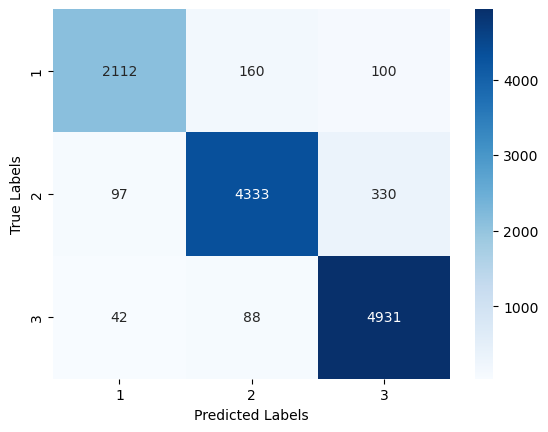

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = predictions.select('prediction').toPandas()['prediction'].values
y_true = predictions.select('accident_severity').toPandas()['accident_severity'].values

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
#calculate the recall and precision of severe accidents
TP = conf_matrix.filter(col("accident_severity") == 3).select(col("3")).collect()[0][0]
FN = conf_matrix.filter(col("accident_severity") == 3).select(col("1") + col("2")).collect()[0][0]
FP = conf_matrix.filter(col("accident_severity").isin([1, 2])).select(col("3")).groupBy().sum().collect()[0][0]
recall = TP / (TP + FN)
precision = TP / (TP + FP)
print("Recall of slight accidents (class 3): %f" % recall)
print("Precision of slight accidents (class 3): %f" % precision)


#calculate the recall and precision of moderately severe accidents
TP = conf_matrix.filter(col("accident_severity") == 2).select(col("2")).collect()[0][0]
FN = conf_matrix.filter(col("accident_severity") == 2).select(col("1") + col("3")).collect()[0][0]
FP = conf_matrix.filter(col("accident_severity").isin([1, 3])).select(col("2")).groupBy().sum().collect()[0][0]
recall = TP / (TP + FN)
precision = TP / (TP + FP)
print("Recall of serious accidents (class 2): %f" % recall)
print("Precision of serious accidents (class 2): %f" % precision)


#calculate the recall and precision of least severe accidents
TP = conf_matrix.filter(col("accident_severity") == 1).select(col("1")).collect()[0][0]
FN = conf_matrix.filter(col("accident_severity") == 1).select(col("2") + col("3")).collect()[0][0]
FP = conf_matrix.filter(col("accident_severity").isin([3, 2])).select(col("1")).groupBy().sum().collect()[0][0]
recall = TP / (TP + FN)
precision = TP / (TP + FP)
print("Recall of fatal accidents (class 1): %f" % recall)
print("Precision of fatal accidents (class 1): %f" % precision)

23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Recall of slight accidents (class 3): 0.974313
Precision of slight accidents (class 3): 0.919791


23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:19:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/16 23:20:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:20:41 WARN RowBasedKeyValueBatch: Calling spill() on

23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on

23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:21:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Recall of serious accidents (class 2): 0.910294
Precision of serious accidents (class 2): 0.947933


23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:06 WARN RowBasedKeyValueBatch: Calling spill() on

23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:22:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/04/16 23:23:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:23:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:23:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:23:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:23:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:23:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:23:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/16 23:23:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Recall of fatal accidents (class 1): 0.893456
Precision of fatal accidents (class 1): 0.938740


In [ ]:
# get best model and parameters
best_model = cv_pipeline.bestModel
best_params = cv_pipeline.getEstimatorParamMaps()[np.argmax(cv_pipeline.avgMetrics)]

# print best parameters
print("Best parameters: ", best_params)


Best parameters:  {Param(parent='DecisionTreeClassifier_1ad196aa378a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='DecisionTreeClassifier_1ad196aa378a', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='DecisionTreeClassifier_1ad196aa378a', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy'}
